In [272]:
import openseespy.opensees as ops
import numpy as np
import opsvis as ovs
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])

### Response Spectra
A plot of the peak value of a response quantity as a function of the natural vibration period $T_n$ of the system, or a related parameter such as circular frequency $ω_n$ or cyclic frequency $f_n$, is called the response spectrum for that quantity. Each such plot is for SDF systems having a fixed damping ratio $\xi$ , and several such plots for different values of $\xi$ are included to cover the range of damping values encountered in actual structures. 

#### Units for this code
1. mass = kg 
2. force = kN
3. Displacement = cm
4. time = s

In [273]:
# ground motion
val = np.loadtxt("ElCentro.txt")
dt = 0.02
dtAnalysis = dt
TmaxAnalysis = 30
nStep = int(TmaxAnalysis/dtAnalysis)

In [274]:
def getModel(uniqueID:int, T:float, Xi:float):
    uniqueID = int(uniqueID)
    ops.node(uniqueID+1, uniqueID)
    ops.node(uniqueID+2, uniqueID)
    ops.fix(uniqueID+1, uniqueID)
    
    w = 2*np.pi / T
    
    m = 45594
    k = w**2 * m
    c = 2*m*w*Xi
    
    ops.mass(uniqueID+2, m)
    
    parallelMat = uniqueID+3
    ops.uniaxialMaterial('Elastic', uniqueID+1, k) #left stiffness param
    ops.uniaxialMaterial('Viscous', uniqueID+2, c, 1) #left damping param
    ops.uniaxialMaterial('Parallel', parallelMat, *[uniqueID+1, uniqueID+2]) #left combined

    ops.element('zeroLength', uniqueID+1, *[uniqueID+1,uniqueID+2], '-mat', parallelMat, '-dir', 1) #element


In [275]:
def applyGroundMotion():
    gmTS = 1
    GM_dirn = 1
    GM_fact = 9.81
    ops.timeSeries("Path", gmTS, '-dt', dt, '-values', *val)
    ops.pattern('UniformExcitation', 300, GM_dirn, '-accel', gmTS, '-fact', GM_fact)

    ops.constraints("Transformation")
    ops.numberer("Plain")
    ops.system("ProfileSPD")
    tol = 1.e-8
    maxNumIter = 50
    ops.test("EnergyIncr", tol, maxNumIter)
    ops.algorithm("ModifiedNewton")
    ops.integrator("Newmark", .5, .25)
    ops.analysis("Transient")

def getResponse(nodeList):

    to_return = {str(node):[] for node in nodeList}

    for i in range(nStep):
        ops.analyze(1, dtAnalysis)
        for node in nodeList:
            to_return[str(node)].append(ops.nodeDisp(int(node), 1)*100)   #in cm

    return to_return

def getMaxResp(responseDict):
    return {k:abs(max(responseDict[k], key=abs)) for (k,v) in responseDict.items()}
      

# Deformation Response Spectrum

### 1. Verification from A.K. Chopra
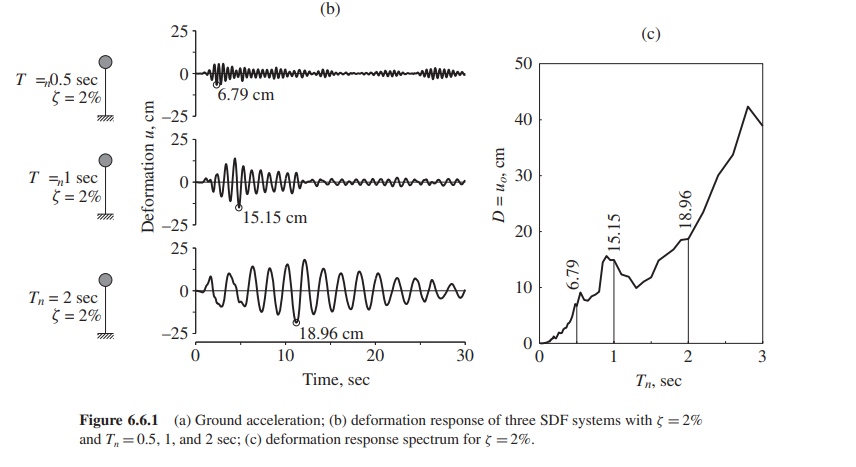

In [276]:
ops.wipe()
ops.model('Basic', '-ndm', 1, '-ndf', 1)

### first lets build our 3 models with following time periods
modelID = [10, 20, 30]
TimePeriod = [.5, 1, 2]
nodeTimeDict = {ID+2:T for (ID,T) in zip(modelID, TimePeriod)}  #to keep track of free node that we are interested in

In [277]:
#now build model
for ID,T in zip(modelID, TimePeriod):
    getModel(ID, T, Xi=0.02)

applyGroundMotion()

In [278]:
response = getResponse(nodeTimeDict.keys())

In [279]:
maxResponse = getMaxResp(response)

In [280]:
maxResponse

{'12': 6.807764149667197, '22': 15.063275193038711, '32': 18.967537556899174}

Hence the maximum responses are verified for our models

## 2. Plotting of Deformation Response Spectra from Time Period 0 to 3s
We must skip 0 time period, as it will lead to infinite frequency

In [254]:
ops.wipe()
ops.model('Basic', '-ndm', 1, '-ndf', 1)

modelID = np.arange(10, 400, 4) # this will create models with time period varying from 0 to 3s
TimePeriod = np.linspace(0.05, 3, len(modelID))

nodeTimeDict = {ID+2:T for (ID,T) in zip(modelID, TimePeriod)}  #to keep track of free node that we are interested in

In [255]:
#now build model
for ID,T in zip(modelID, TimePeriod):
    getModel(ID, T, Xi=0.02)

applyGroundMotion()

In [256]:
%%time
response = getResponse(nodeTimeDict.keys())
maxResponse = getMaxResp(response)

CPU times: total: 500 ms
Wall time: 512 ms


Text(0, 0.5, 'D = $u_0$, cm')

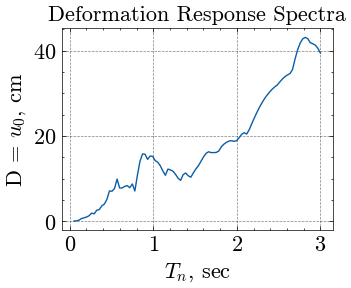

In [267]:
plt.plot(TimePeriod, maxResponse.values())
plt.title("Deformation Response Spectra")
plt.xlabel(r"$T_n$, sec")
plt.ylabel(r"D = $u_0$, cm")


In [258]:
DeformationResponseSpectrum = np.array(list(maxResponse.values())) # convert dict values to np array

PseudoVelocityResponseSpectrum = np.array(list(maxResponse.values()))*2*np.pi/TimePeriod

PseudoAccelResponseSpectrum = (np.array(list(maxResponse.values()))*(2*np.pi/TimePeriod)**2)/981  # convert into pgs so divide by 981 cm/s^2

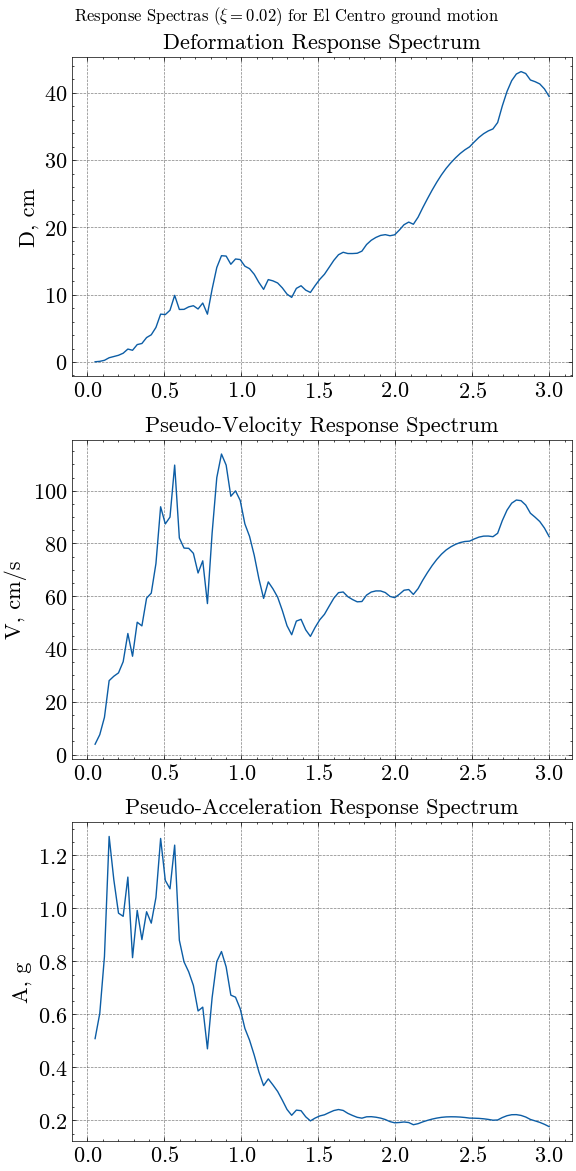

In [259]:
fig, ax = plt.subplots(3,1, figsize=(6,12), tight_layout = True)

ax[0].plot(TimePeriod, DeformationResponseSpectrum)
ax[0].set_ylabel("D, cm")
ax[0].set_title("Deformation Response Spectrum")
ax[1].plot(TimePeriod, PseudoVelocityResponseSpectrum)
ax[1].set_title("Pseudo-Velocity Response Spectrum")
ax[1].set_ylabel("V, cm/s")
ax[2].plot(TimePeriod, PseudoAccelResponseSpectrum) #to convert into pga 981 cm/s^2
ax[2].set_title("Pseudo-Acceleration Response Spectrum")
ax[2].set_ylabel("A, g")
plt.suptitle(r"Response Spectras $(\xi=0.02)$ for El Centro ground motion")
plt.show()

### Significances of Various Response Spectras
1. **Deformation Response Spectra:**  Peak deformation of a system
2. **Pseudo-velocity spectrum:** Peak value of strain energy stored in the system during earthquake
3. **Pseudo-acceleration spectrum:** Peak value of equivalent static force and base shear

> Note: We have expressed PseudoAccelerationResponseSpectrum as PseudoAcceleration (A) / g (accel. due to gravity). This term A/g is **Base Shear Coefficient** or **Lateral Force Coefficient**. The lateral force is given by $w*A/g$ where $w$ is the weight of the structure

### Now creating for various xi values too

In [268]:
XI = np.array([0, 0.02, 0.05, 0.1, 0.2])

DeformationResponseSpectrum = {str(xi):[] for xi in XI} #np.array(list(maxResponse.values())) # convert dict values to np array
PseudoVelocityResponseSpectrum = {str(xi):[] for xi in XI} #np.array(list(maxResponse.values()))*2*np.pi/TimePeriod
PseudoAccelResponseSpectrum = {str(xi):[] for xi in XI}#(np.array(list(maxResponse.values()))*(2*np.pi/TimePeriod)**2)/981  # convert into pgs so divide by 981 cm/s^2

In [269]:
def unequal_spacing(start, end, num_points, concentration_points):
    """
    Create an array with unequal spacing between `start` and `end`.
    
    Parameters:
        start (float): The starting value.
        end (float): The ending value.
        num_points (int): The total number of points.
        concentration_points (list of tuples): Each tuple contains (value, weight).
    
    Returns:
        np.ndarray: The resulting array with custom spacing.
    """
    # Create points for each concentration point
    points = []
    for point, weight in concentration_points:
        # Generate points around each concentration
        concentrated_points = np.random.uniform(point - weight, point + weight, size=int(num_points * 0.2))  # 20% concentrated
        points.append(concentrated_points)
    
    # Generate the rest of the points uniformly
    uniform_points = np.random.uniform(start, end, size=num_points - sum(len(p) for p in points))
    
    # Combine all points and sort them
    all_points = np.concatenate(points + [uniform_points])
    result = np.unique(all_points)  # Remove duplicates
    result.sort()
    
    return result


In [270]:
%%time

# ground motion
val = np.loadtxt("ElCentro.txt")
dt = 0.02
dtAnalysis = dt
TmaxAnalysis = 30
nStep = int(TmaxAnalysis/dtAnalysis)

modelID = np.arange(10, 8000, 4) # this will create models with time period varying from 0 to 3s
TimePeriod = np.linspace(0.05, 50, len(modelID))
#TimePeriod = unequal_spacing(0.05, 50, len(modelID), [(1, .5), (2, .5), (.2, .5), (20, .1), (50, .1)])  #

nodeTimeDict = {ID+2:T for (ID,T) in zip(modelID, TimePeriod)}  #to keep track of free node that we are interested in

for xi in XI:
    ops.wipe()
    ops.model('Basic', '-ndm', 1, '-ndf', 1)

    #now build model
    for ID,T in zip(modelID, TimePeriod):
        getModel(ID, T, xi)
    
    applyGroundMotion()
    response = getResponse(nodeTimeDict.keys())
    maxResponse = getMaxResp(response)

    DeformationResponseSpectrum[str(xi)] = [TimePeriod, np.array(list(maxResponse.values()))]
    PseudoVelocityResponseSpectrum[str(xi)] = [TimePeriod, np.array(list(maxResponse.values()))*2*np.pi/TimePeriod]  
    PseudoAccelResponseSpectrum[str(xi)] = [TimePeriod, (np.array(list(maxResponse.values()))*(2*np.pi/TimePeriod)**2)/981]

CPU times: total: 1min 35s
Wall time: 1min 36s


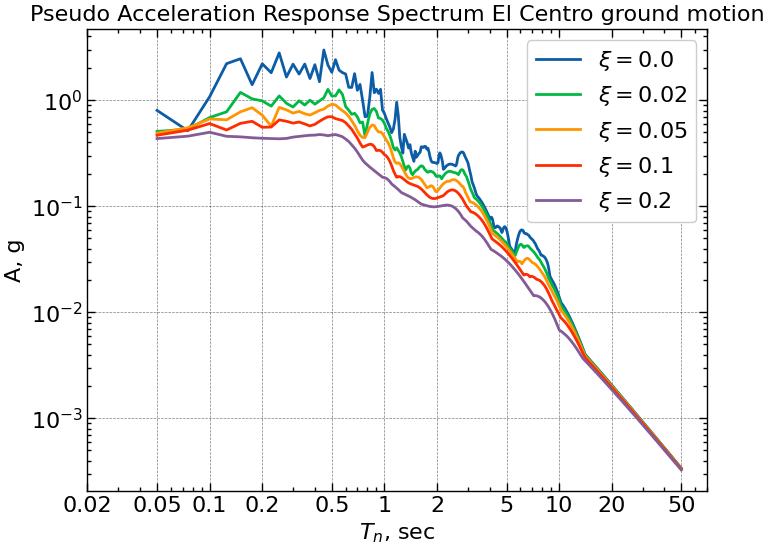

In [281]:
for xi,val in PseudoAccelResponseSpectrum.items():
    plt.plot(val[0], val[1], label=rf"$\xi = ${xi}")

plt.title(r"Pseudo Acceleration Response Spectrum El Centro ground motion")
plt.xlabel(r"$T_n$, sec")
plt.ylabel(r"A, g")
plt.xscale('log')
plt.xticks(ticks=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50], labels=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50])
plt.yscale('log')
#plt.yticks(ticks=[1, 2, 5, 10, 20, 50, 100, 200], labels=[1, 2, 5, 10, 20, 50, 100, 200])
#plt.xlim([0,4])
plt.legend()
plt.show()

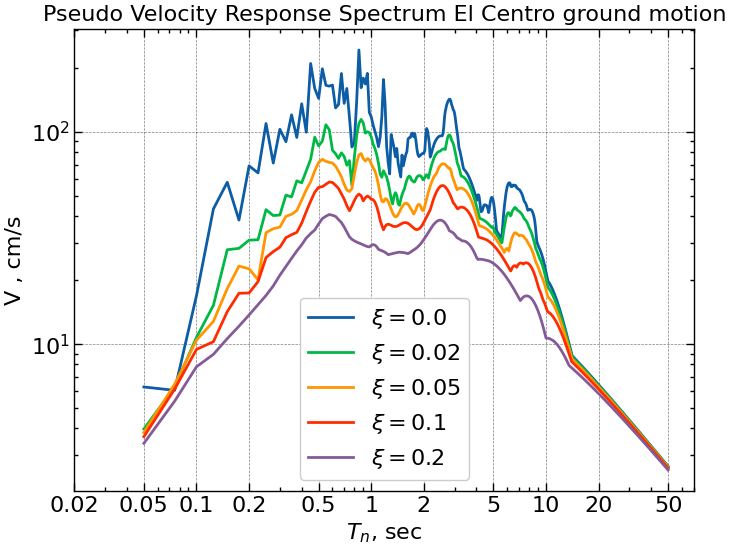

In [282]:
for xi,val in PseudoVelocityResponseSpectrum.items():
    plt.plot(val[0], val[1], label=rf"$\xi = ${xi}")

plt.title(r"Pseudo Velocity Response Spectrum El Centro ground motion")
plt.xlabel(r"$T_n$, sec")
plt.ylabel(r"V , cm/s")
plt.xscale('log')
plt.xticks(ticks=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50], labels=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50])
plt.yscale('log')
plt.legend()
plt.show()

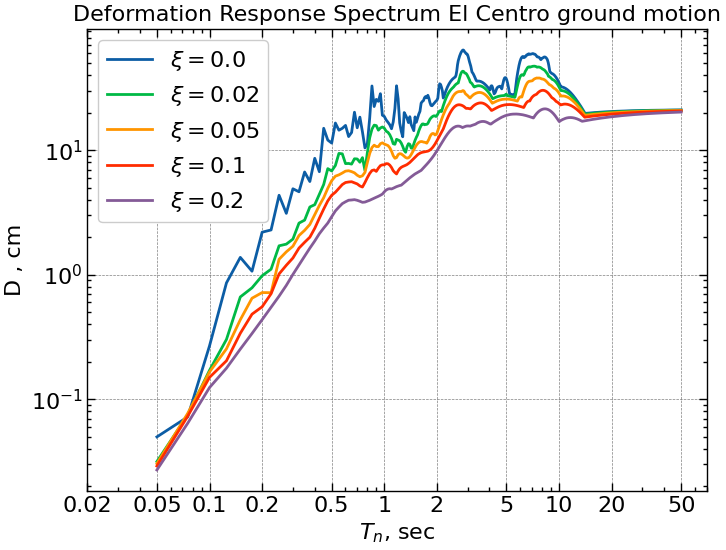

In [64]:
for xi,val in DeformationResponseSpectrum.items():
    plt.plot(val[0], val[1], label=rf"$\xi = ${xi}")


plt.title(r"Deformation Response Spectrum El Centro ground motion")
plt.xlabel(r"$T_n$, sec")
plt.ylabel(r"D , cm")
plt.xscale('log')
plt.xticks(ticks=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50], labels=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50])
plt.yscale('log')

plt.legend()
plt.show()

### These 3 plots are similar to each other in shape, but are oriented with some axes rotation only, so practically they can be represented in a same graph
Lets plot them together


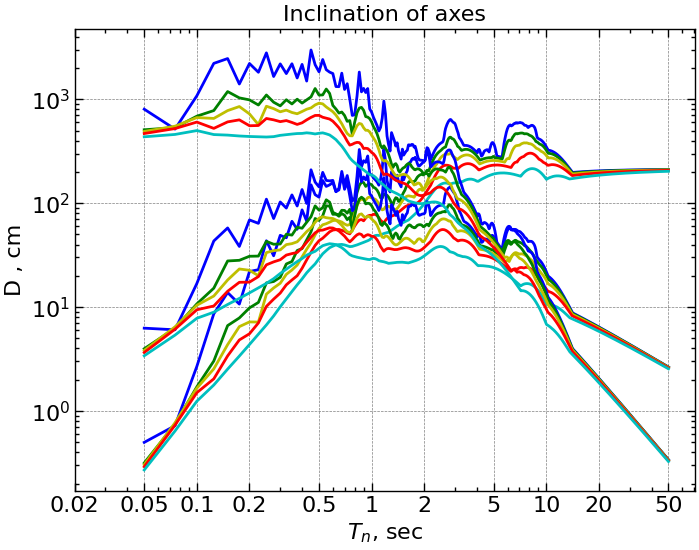

In [100]:
c = ['b', 'g', 'y', 'r', 'c']
color_it = iter(c)

for xi,val in DeformationResponseSpectrum.items():
    plt.plot(val[0], val[1]*10, color = next(color_it))

c = ['b', 'g', 'y', 'r', 'c']
color_it = iter(c)
for xi,val in PseudoVelocityResponseSpectrum.items():
    plt.plot(val[0], val[1], color = next(color_it))

c = ['b', 'g', 'y', 'r', 'c']
color_it = iter(c)
for xi,val in PseudoAccelResponseSpectrum.items():
    plt.plot(val[0], val[1]*10e2, label=rf"$\xi = ${xi}", color = next(color_it))

plt.title(r"Inclination of axes")
plt.xlabel(r"$T_n$, sec")
plt.ylabel(r"D , cm")
plt.xscale('log')
plt.xticks(ticks=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50], labels=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50])
plt.yscale('log')

#plt.legend()
plt.show()

## Combined D-V-A Spectrum
Each of the deformation, pseudo-velocity, and pseudo-acceleration response spectra for a given
ground motion contains the same information, no more and no less. The three spectra are simply different ways of presenting the same information on structural response. Knowing one of the
spectra, the other two can be obtained by algebraic operations.

Why do we need three spectra when each of them contains the same information? One of
the reasons is that each spectrum directly provides a physically meaningful quantity. The deformation spectrum provides the peak deformation of a system. The pseudo-velocity spectrum is related
directly to the peak strain energy stored in the system during the earthquake. The
pseudo-acceleration spectrum is related directly to the peak value of the equivalent static force and
base shear. The second reason lies in the fact that the shape of the spectrum can be
approximated more readily for design purposes with the aid of all three spectral quantities rather
than any one of them alone. For this purpose a combined plot showing all
three of the spectral quantities is especially useful. This type of plot was developed for earthquake
response spectra, apparently for the first time, by A. S. Veletsos and N. M. Newmark in 1960.

This integrated presentation is possible because the three spectral quantities are interrelated by Eqns:

$\displaystyle{ \frac{A}{\omega_n} = V = \omega_n D }$

> We can note a bit inclined plots in each of previous graph

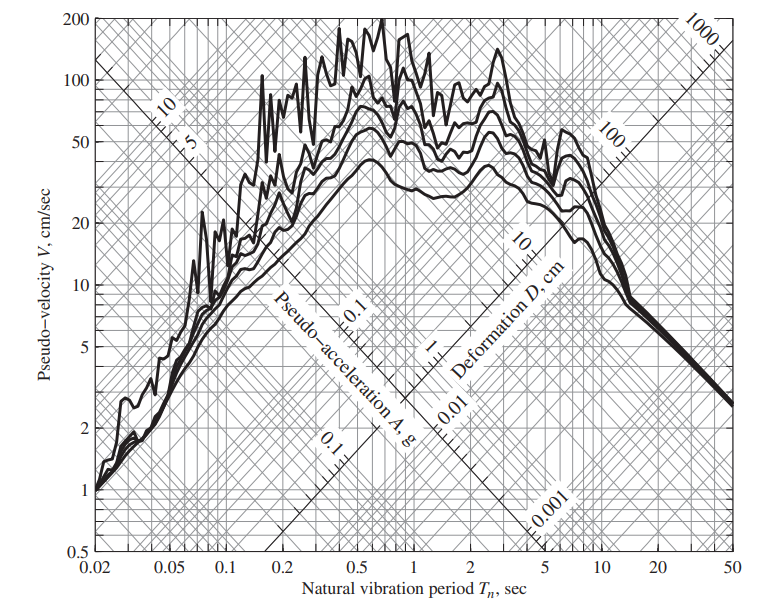

### Python script to plot combined D-A-V plot or Tripartite Graph
#### Source: A.K. Jain .7.1 MATLAB Code

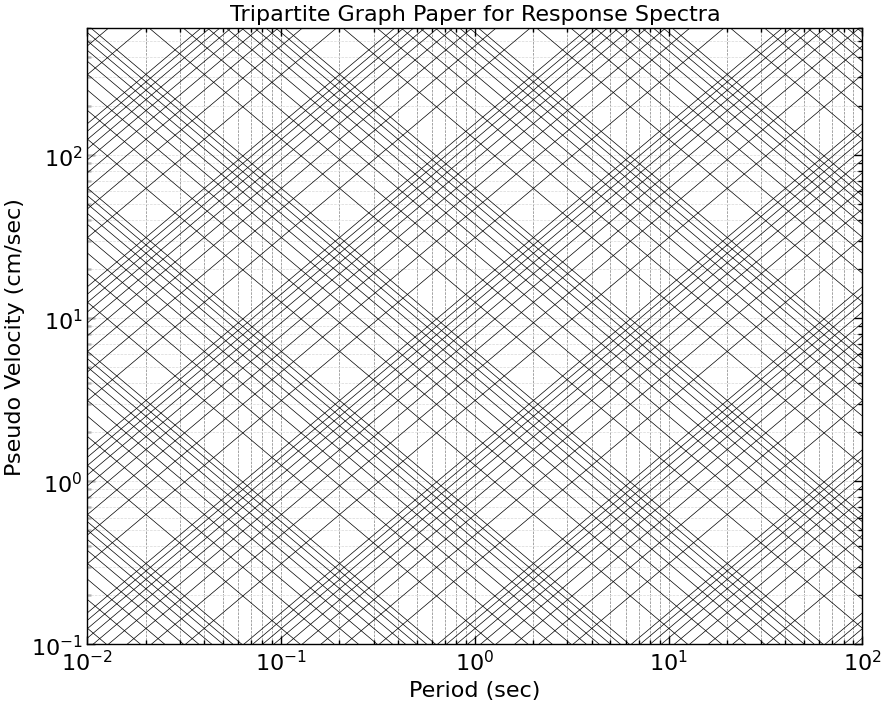

In [204]:
def drawTripartiteGraph(xlim = [0.01, 100], ylim = [0.1, 600] ):
    # Constants
    Tmin = 0.01
    Tmax = 600
    Vmin = 0.01
    Vmax = 600
    Agmin = 0.0001
    Agmax = 90
    Dmin = 0.001
    Dmax = 10000
    g = 981.0  # Acceleration due to gravity in cm/s²
    
    # Compute vertical grid (Period T)
    t = []
    for i in range(1, 5):
        for j in range(1, 10):
            t.append(j * 10 ** (i - 3))

    # Compute horizontal grid (Pseudo Velocity)
    v = []
    for i in range(1, 5):
        for j in range(1, 10):
            v.append(j * 10 ** (i - 2))
    
    # Compute acceleration grid (Spectral Acceleration)
    a = []
    for i in range(-1, 8):
        for j in range(1, 10):
            a.append(j * 10 ** (i - 5))
    
    # Compute displacement grid (Spectral Displacement)
    d = []
    for i in range(-1, 9):
        for j in range(1, 10):
            d.append(j * 10 ** (i - 4))
    
    # Plot the tripartite graph
    plt.figure(figsize=(10, 8))
    
    # Plot vertical grid (log-log)
    for vi in v:
        plt.plot(t, [vi] * len(t), 'w', lw=0.5)
    
    # Plot acceleration grid
    A1 = 2 * np.pi * Vmin / (Tmax * g)
    A2 = 2 * np.pi * Vmin / (Tmin * g)
    A3 = 2 * np.pi * Vmax / (Tmax * g)
    A4 = 2 * np.pi * Vmax / (Tmin * g)
    
    ta1i = 1
    ta3i = 1
    for ai in a:
        if A1 <= ai <= A3:
            ta = 2 * np.pi * Vmin / (g * ai)
            va = Tmax / (2 * np.pi) * ai * g
            plt.plot([ta, Tmax], [Vmin, va], 'k', lw=0.5)
    
        if A2 > A3 and A3 <= ai <= A2:
            ta1 = 2 * np.pi * Vmin / (ai * g)
            ta2 = 2 * np.pi * Vmax / (ai * g)
            plt.plot([ta1, ta2], [Vmin, Vmax], 'k', lw=0.5)
    
        if A2 <= ai <= A4:
            va3 = Tmin / (2 * np.pi) * ai * g
            ta3 = 2 * np.pi * Vmax / (ai * g)
            plt.plot([Tmin, ta3], [va3, Vmax], 'k', lw=0.5)
    
    # Plot displacement grid
    D1 = Tmin * Vmin / (2 * np.pi)
    D2 = Tmin * Vmax / (2 * np.pi)
    D3 = Tmax * Vmin / (2 * np.pi)
    D4 = Tmax * Vmax / (2 * np.pi)
    
    tdi = 1
    td1i = 1
    td3i = 1
    for di in d:
        if D1 <= di <= D2:
            td = 2 * np.pi * di / Vmin
            vd = 2 * np.pi * di / Tmin
            plt.plot([Tmin, vd], [td, Vmin], 'k', lw=0.5)
    
        if D3 > D2 and D2 <= di <= D3:
            td1 = 2 * np.pi * di / Vmax
            td2 = 2 * np.pi * di / Vmin
            plt.plot([td1, td2], [Vmax, Vmin], 'k', lw=0.5)
    
        if D3 <= di <= D4:
            td3 = 2 * np.pi * di / Vmax
            vd3 = 2 * np.pi * di / Tmax
            plt.plot([td3, Vmax], [Tmax, vd3], 'k', lw=0.5)
    

    # Axis limits and labels
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
     
    plt.xlabel('Period (sec)')
    plt.ylabel('Pseudo Velocity (cm/sec)')
    plt.title('Tripartite Graph Paper for Response Spectra')
    

drawTripartiteGraph()

### Lets plot Tripartite response spectrum for El Centro Earthquake

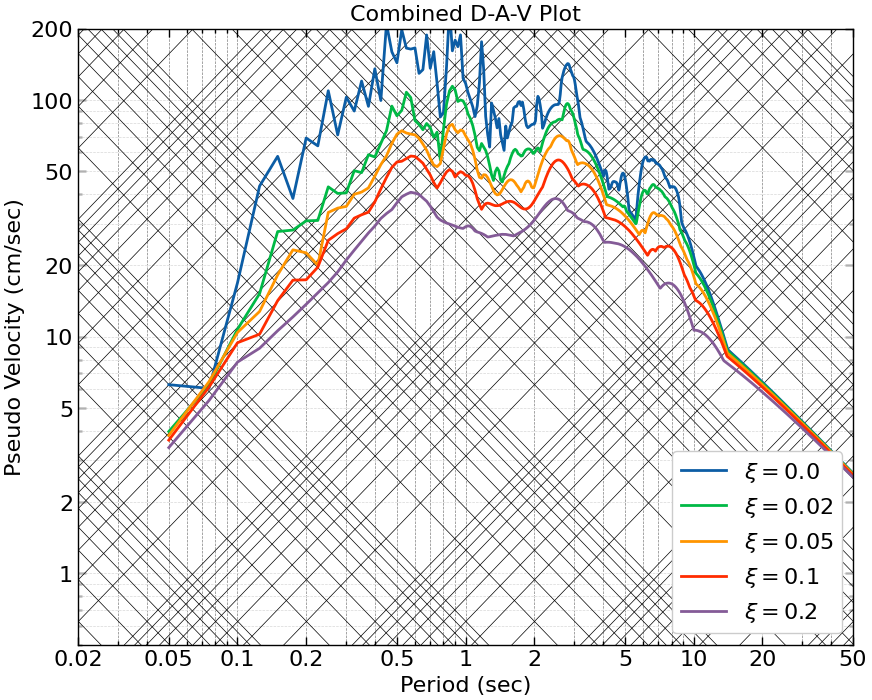

In [214]:
drawTripartiteGraph(xlim=(0.02, 50), ylim=(.5, 200))
for xi,val in PseudoVelocityResponseSpectrum.items():
    plt.plot(val[0], val[1], label=rf"$\xi = ${xi}")

plt.xticks(ticks=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50], labels=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50])
plt.yticks(ticks=[1, 2, 5, 10, 20, 50, 100, 200], labels=[1, 2, 5, 10, 20, 50, 100, 200])

plt.legend(loc='lower right')
plt.title("Combined D-A-V Plot")
plt.show()

#### Normalized Pseudo Acceleration Response Spectrum

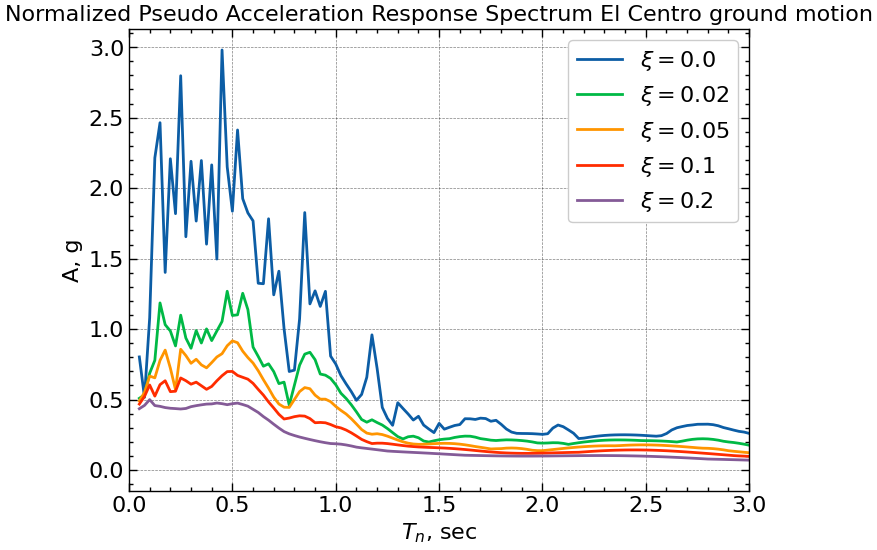

In [216]:
for xi,val in PseudoAccelResponseSpectrum.items():
    plt.plot(val[0], val[1], label=rf"$\xi = ${xi}")

plt.title(r"Normalized Pseudo Acceleration Response Spectrum El Centro ground motion")
plt.xlabel(r"$T_n$, sec")
plt.ylabel(r"A, g")
#plt.xscale('log')
#plt.xticks(ticks=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50], labels=[0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50])
#plt.yscale('log')

plt.xlim([0,3])
plt.legend()
plt.show()